In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

import helper as hp

from random import sample

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using Theano backend.



You can find the C code in this temporary file: /var/folders/68/y0pqkpw91k53y02d1g65fy700000gn/T/theano_compilation_error_pbszsf02


Exception: Compilation failed (return status=1): ld: unsupported tapi file type '!tapi-tbd' in YAML file '/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/lib/libSystem.tbd' for architecture x86_64. clang-10: error: linker command failed with exit code 1 (use -v to see invocation). 

In [83]:
def load_dataframe(filename):
    dataframe = pd.read_csv(filename)
    dataframe.drop(columns = ['Unnamed: 0'], inplace = True)
    print('Found {} rows '.format(str(len(dataframe))))
    return dataframe

In [84]:
all_train_df = load_dataframe('full_datasets/all_train.csv')
all_train_df.head()

Found 7224612 rows 


,label,path
0,Lube,/2425/1/115_Lube_45484.jpg
1,Spencerian,/2425/1/114_Spencerian_73323.jpg
2,accommodatingly,/2425/1/113_accommodatingly_613.jpg
3,CARPENTER,/2425/1/112_CARPENTER_11682.jpg
4,REGURGITATING,/2425/1/111_REGURGITATING_64100.jpg


In [85]:
all_valid_df = load_dataframe('full_datasets/all_validation.csv')
all_valid_df.head()

Found 802734 rows 


,label,path
0,MONIKER,/2697/6/466_MONIKER_49537.jpg
1,Ecclesiastics,/2697/6/465_Ecclesiastics_24500.jpg
2,FIRESTORM,/2697/6/464_FIRESTORM_29099.jpg
3,Psi,/2697/6/463_Psi_60982.jpg
4,Repurchases,/2697/6/462_Repurchases_64997.jpg


In [86]:
all_test_df = load_dataframe('full_datasets/all_test.csv')
all_test_df.head()

Found 891927 rows 


,label,path
0,slinking,/3000/7/182_slinking_71711.jpg
1,REMODELERS,/3000/7/181_REMODELERS_64541.jpg
2,Chronographs,/3000/7/180_Chronographs_13538.jpg
3,Impeaching,/3000/7/179_Impeaching_38222.jpg
4,discombobulated,/3000/7/178_discombobulated_22063.jpg


In [87]:
df = all_train_df['label'].str.lower()
df.head()

0               lube
1         spencerian
2    accommodatingly
3          carpenter
4      regurgitating
Name: label, dtype: object

<AxesSubplot:>

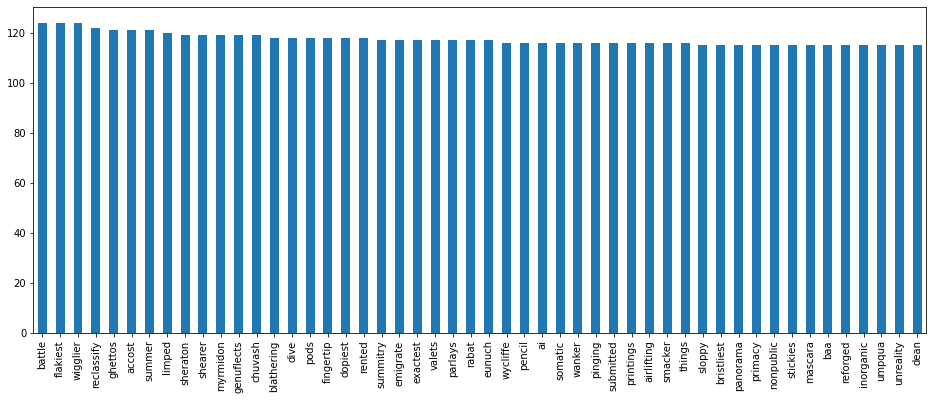

In [92]:
plt.figure(figsize = (16,6))
df.value_counts()[:50].plot(kind = 'bar')

In [93]:
def create_full_directory(df):
    directory = hp.assets_directory()
    df['path'] = directory + df['path']
    return df

In [94]:
train_df = all_train_df.sample(100)
valid_df = all_valid_df.sample(20)
test_df = all_test_df.sample(20)
print('Training dataset size: ' + str(len(train_df)))
print('Validation dataset size: ' + str(len(valid_df)))
print('Test dataset size: ' + str(len(test_df)))

Training dataset size: 100
Validation dataset size: 20
Test dataset size: 20


In [95]:
train_df = create_full_directory(train_df)
valid_df = create_full_directory(valid_df)
test_df = create_full_directory(test_df)

In [96]:
train_df['path'].values[:10]

array(['/Users/jbenavidesv/Workspace/ocr_detector/90kDICT32px/91/6/327_Afford_1439.jpg',
       '/Users/jbenavidesv/Workspace/ocr_detector/90kDICT32px/590/6/216_Washbowls_85546.jpg',
       '/Users/jbenavidesv/Workspace/ocr_detector/90kDICT32px/1886/5/158_Shiftily_70181.jpg',
       '/Users/jbenavidesv/Workspace/ocr_detector/90kDICT32px/577/7/130_Nasalizing_50933.jpg',
       '/Users/jbenavidesv/Workspace/ocr_detector/90kDICT32px/1141/4/324_cattleman_12096.jpg',
       '/Users/jbenavidesv/Workspace/ocr_detector/90kDICT32px/2150/7/155_Intermingling_40261.jpg',
       '/Users/jbenavidesv/Workspace/ocr_detector/90kDICT32px/1180/5/334_despoiled_21066.jpg',
       '/Users/jbenavidesv/Workspace/ocr_detector/90kDICT32px/230/6/303_Sandpapering_67692.jpg',
       '/Users/jbenavidesv/Workspace/ocr_detector/90kDICT32px/500/1/196_baggier_5498.jpg',
       '/Users/jbenavidesv/Workspace/ocr_detector/90kDICT32px/1393/2/266_Onstage_53416.jpg'],
      dtype=object)

In [147]:
# IMG_SIZE = (32, 64)
IMG_SIZE = (224, 224)
CLASS_MODE = 'categorical'
def image_augmentation():
    return ImageDataGenerator(rescale = 1./255.0,
                             horizontal_flip = False,
                             vertical_flip = False,
                             height_shift_range = 0.1,
                             width_shift_range = 0.1,
                             rotation_range = 20,
                             shear_range = 0.1,
                             zoom_range = 0.1)
def make_train_gen(df):
    img_data_generator = image_augmentation()
    return img_data_generator.flow_from_dataframe(dataframe = df,
                                        x_col = 'path',
                                        y_col = 'label',
                                        class_mode = CLASS_MODE,
                                        target_size = IMG_SIZE,
                                        batch_size = 32)

def make_valid_gen(df):
    img_data_generator = ImageDataGenerator(rescale = 1.0 / 255.0)
    return img_data_generator.flow_from_dataframe(dataframe = df,
                                        x_col = 'path',
                                        y_col = 'label',
                                        class_mode = CLASS_MODE,
                                        target_size = IMG_SIZE,
                                        batch_size = 32)

def make_test_gen(df):
    img_data_generator = ImageDataGenerator(rescale = 1.0 / 255.0)
    return img_data_generator.flow_from_dataframe(dataframe = df,
                                        x_col = 'path',
                                        y_col = 'label',
                                        class_mode = CLASS_MODE,
                                        target_size = IMG_SIZE,
                                        batch_size = 32)

In [148]:
train_gen = make_train_gen(train_df)
valid_gen = make_valid_gen(valid_df)
test_gen = make_test_gen(test_df)

## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = valid_gen.next()

Found 100 validated image filenames belonging to 100 classes.
Found 20 validated image filenames belonging to 20 classes.
Found 20 validated image filenames belonging to 20 classes.


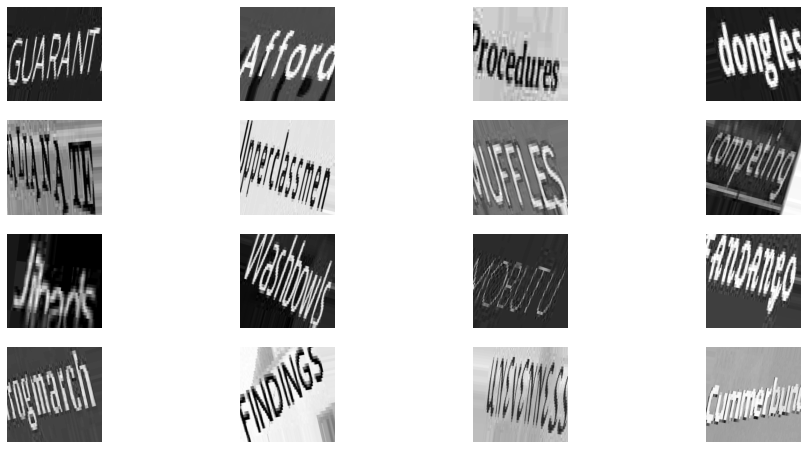

In [149]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'gray')
    c_ax.axis('off')

# Build Model

In [150]:
def load_pretrained_model(lay_of_interest):
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    return vgg_model

In [151]:
def build_my_model(model):
    
    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    my_model = Sequential()
    my_model.add(model)
    
    # Flatten the ouput as it is from a convolutional layer
    my_model.add(Flatten())
    
    # Add a FC layer
#     my_model.add(Dense(1024, activation = 'relu'))
#     my_model.add(Dropout(0.2))

#     my_model.add(Dense(512, activation = 'relu'))
#     my_model.add(Dropout(0.2))
    
    # Add a fully-connected layer at the end
    my_model.add(Dense(1, activation = 'sigmoid'))
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model

In [152]:
weight_path="{}_my_model.best.hdf5".format('xray_class')
METRIC_TO_MONITOR = 'val_loss'
MODE = 'min'
checkpoint = ModelCheckpoint(weight_path, 
                             monitor= METRIC_TO_MONITOR, 
                             verbose=1, 
                             save_best_only=True, 
                             mode= MODE, 
                             save_weights_only = True)

early = EarlyStopping(monitor= METRIC_TO_MONITOR, 
                      mode= MODE, 
                      patience=5)

callbacks_list = [checkpoint, early]

# Start Training!

In [153]:
lay_of_interest = 'block5_pool'
vgg_model = load_pretrained_model(lay_of_interest)
vgg_model.summary()

# We will freeze all but the fifth block
size = len(vgg_model.layers)
for layer in vgg_model.layers[:size - 2]:
    layer.trainable = False

# Print the layers to check everything is fine
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

TypeError: pool_2d() got an unexpected keyword argument 'ws'